In [198]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

## Load annotations

In [7]:
with open("../data/train.json", "rb") as f:
    annotations = json.load(f)

In [9]:
annotations.keys()

dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])

In [18]:
images_df = pd.DataFrame(annotations["images"]).set_index("id")
annotations_df = pd.DataFrame(annotations["annotations"]).set_index("id")
categories_df = pd.DataFrame(annotations["categories"]).set_index("id")

In [19]:
images_df.head()

,width,height,file_name,license,flickr_url,coco_url,date_captured
id,,,,,,,
1,1920,1080,754e6a28-a8eb-4cb3-a0b9-3f2d5daacbae.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2016-06-16 00:00:00
2,1920,1080,212db4d6-450d-404f-8973-1c911b5e1171.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2016-06-16 00:00:00
4,1920,1080,51d854e9-af94-43c3-b40c-f90c76e67327.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2016-06-16 00:00:00
5,720,486,dbc11dc2-91b5-4742-8318-f1805717a715.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2013-12-12 00:00:00
6,1920,1080,691bbe67-06fd-498b-a721-05181356da59.png,0,https://fathomnet.org/static/m3/staging/Doc%20...,https://fathomnet.org/static/m3/staging/Doc%20...,2016-06-16 00:00:00


In [20]:
annotations_df.head()

,image_id,category_id,segmentation,area,bbox,iscrowd
id,,,,,,
5,4927,12,[],660.0,"[347.0, 174.0, 33.0, 20.0]",0
6,4928,14,[],29520.0,"[291.0, 167.0, 205.0, 144.0]",0
7,4929,10,[],5700.0,"[38.0, 216.0, 76.0, 75.0]",0
8,4930,10,[],3913.0,"[258.0, 363.0, 91.0, 43.0]",0
9,4931,10,[],720.0,"[134.0, 116.0, 40.0, 18.0]",0


In [21]:
categories_df.head()

,name,supercategory
id,,
1,Anemone,
2,Barnacle,
3,Black coral,
4,Crab,
5,Eel,


## Visualise

In [105]:
def get_image_info(image_id, images_df, annotations_df, categories_df, image_folder):
    img_fname = images_df.loc[image_id, "file_name"]
    image = io.imread(os.path.join(image_folder, img_fname))
    annotations = annotations_df[annotations_df.image_id == image_id]
    bboxes = annotations.bbox.explode().to_numpy(dtype=float).reshape(-1, 4)
    cat_ids = annotations.category_id.to_numpy(dtype=int)
    return image, bboxes, cat_ids

In [138]:
def show_annotations(image, bboxes, cats, wh=True):
    plt.imshow(image)
    n = cats.shape[0]
    for i in range(n):
        if wh:
            x, y, w, h = [int(b) for b in bboxes[i]]
        else:
            x, y, xmax, ymax = [int(b) for b in bboxes[i]]
            w = xmax-x
            h = ymax-y
        class_id = cats[i]
        class_name = categories_df.loc[class_id]["name"]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, facecolor='none', edgecolor="blue")
        t_box = ax.text(x, y, class_name, color="red", fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        ax.add_patch(rect)
    

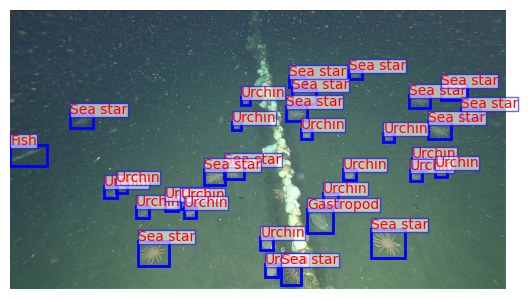

In [111]:
fig, ax = plt.subplots(1, 1)
ax.axis('off')
image, bbox, cats = get_image_info(126, images_df, annotations_df, categories_df, "../data/train")
show_annotations(image, bbox, cats)
plt.show()

## Dataset

In [203]:
class Fathom24Dataset(Dataset):
    """Fathom2024 dataset."""

    def __init__(self, json_file, root_dir, transform=None):
        """
        Arguments:
            json_file (string): Path to the json file with COCO annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        with open(json_file, "rb") as f:
            annotations = json.load(f)
        self.images_df = pd.DataFrame(annotations["images"])
        self.annotations_df = pd.DataFrame(annotations["annotations"]).set_index("id")
        self.categories_df = pd.DataFrame(annotations["categories"]).set_index("id")
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.images_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.images_df.loc[idx].id
        img_name = os.path.join(self.root_dir,
                                self.images_df.loc[idx, "file_name"])
        image = io.imread(img_name)
        annotations = annotations_df[annotations_df.image_id == img_id]
        bboxes = annotations.bbox.explode().to_numpy(dtype=float).reshape(-1, 4)
        # Faster RCNN expects boxes as xmin, ymin, xmax, ymax
        bboxes_transformed = bboxes[:,:2]
        bboxes_transformed = np.hstack((bboxes_transformed, (bboxes[:,0] + bboxes[:,2]).reshape(-1, 1)))
        bboxes_transformed = np.hstack((bboxes_transformed, (bboxes[:,1] + bboxes[:,3]).reshape(-1, 1)))
        cat_ids = annotations.category_id.to_numpy(dtype=int)

        annotations = {'boxes': bboxes_transformed, 'labels': cat_ids}

        sample = (image, annotations)

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (1080, 1920, 3) (198, 4) (198,)
1 (1080, 1920, 3) (154, 4) (154,)
2 (1080, 1920, 3) (137, 4) (137,)
3 (486, 720, 3) (131, 4) (131,)


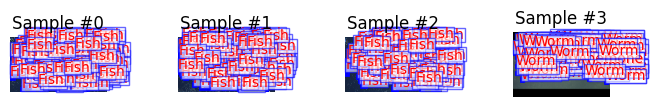

In [204]:
f24_dataset = Fathom24Dataset(json_file="../data/train.json",
                              root_dir="../data/train")
fig = plt.figure()

for i, sample in enumerate(f24_dataset):
    print(i, sample[0].shape, sample[1]['boxes'].shape, sample[1]['labels'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_annotations(sample[0], sample[1]['boxes'], sample[1]['labels'], wh=False)

    if i == 3:
        plt.show()
        break

### Transform

In [236]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, bboxes, cats = sample[0], sample[1]['boxes'], sample[1]['labels']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        bboxes = bboxes * [new_w / w, new_h / h, new_w / w, new_h / h]

        return img, {'boxes': bboxes, 'labels': cats}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, bboxes, cats = sample[0], sample[1]['boxes'], sample[1]['labels']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return torch.from_numpy(image).float(), {
            'boxes': torch.from_numpy(bboxes), 
            'labels': torch.from_numpy(cats)
            }
                

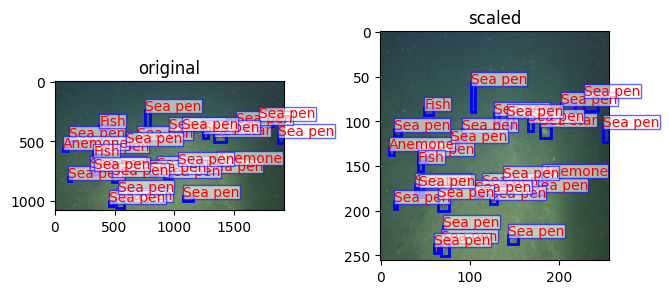

In [232]:
sample = f24_dataset[124]
scale = Rescale((256, 256))
transformed_sample = scale(sample)

plt.figure()
ax = plt.subplot(1, 2, 1)
plt.tight_layout()
ax.set_title("original")
show_annotations(sample[0], sample[1]['boxes'], sample[1]['labels'], wh=False)

ax = plt.subplot(1, 2, 2)
plt.tight_layout()
ax.set_title("scaled")
show_annotations(transformed_sample[0], transformed_sample[1]['boxes'], transformed_sample[1]['labels'], wh=False)

plt.show()

In [237]:
transformed_f24_dataset = Fathom24Dataset(json_file="../data/train.json",
                              root_dir="../data/train",
                              transform=transforms.Compose([
                                Rescale((256, 256)),
                                ToTensor()
                              ]))


### Batching

In [217]:
def collate_fn(batch):  # needed for dictionary data
    return tuple(zip(*batch))

In [238]:
data_loader = DataLoader(transformed_f24_dataset, batch_size=4, shuffle=False, num_workers=0, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Training

In [219]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [226]:
num_classes = 19
num_epochs = 2
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

In [239]:
for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

: 